In [ ]:
import torch
import random
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt


#Воспроизводимость экспериментов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Загрузка датасета MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
#Размерность датасета
X_train.shape

torch.Size([60000, 28, 28])

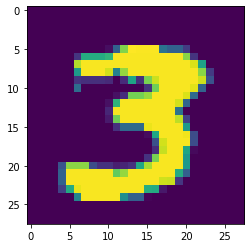

tensor(3)


In [ ]:
#Проверка работы нейросети
import matplotlib.pyplot as plt
plt.imshow(X_train[27])
plt.show()
print(y_train[27])

In [ ]:
#Растягивание картинок
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
#Создание нейросети
class MNISTNet(torch.nn.Module): 
    def __init__(self, n_hidden_neurons): 
        super(MNISTNet, self).__init__() 
        self.fc1 = torch.nn.Linear(784, n_hidden_neurons) 
        self.ac1 = torch.nn.Sigmoid() 
        #self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons) 
        #self.ac2 = torch.nn.Sigmoid() 
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 10) 
        self.af3 = torch.nn.Softmax()
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.ac1(x)
        #x = self.fc2(x) 
        #x = self.ac2(x)  
        x = self.fc3(x) 
        x = self.af3(x)
        return x 

def init_weights(m):
  if type(m) == torch.nn.Linear:
    torch.nn.init.xavier_normal(m.weight)
    m.bias.data.fill_(0.01)

mnist_net = MNISTNet(20)
mnist_net.apply(init_weights)

MNISTNet(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (ac1): Sigmoid()
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (af3): Softmax(dim=None)
)

In [ ]:
#Перенос вычислений на GPU
#torch.cuda.is_available()

#!nvidia-smi

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#mnist_net = mnist_net.to(device)
#list(mnist_net.parameters())

Tue Jun  1 01:37:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[Parameter containing:
 tensor([[ 0.0787,  0.0370, -0.0131,  ..., -0.0875,  0.0747, -0.0774],
         [-0.0284,  0.0503, -0.0144,  ..., -0.0223, -0.0023,  0.0240],
         [ 0.0812,  0.0114, -0.0265,  ..., -0.0142,  0.0188,  0.1156],
         ...,
         [ 0.0491,  0.0723,  0.1093,  ...,  0.0324, -0.0438, -0.0868],
         [-0.0547,  0.0007,  0.0536,  ...,  0.0488, -0.0104, -0.0457],
         [-0.0632,  0.0005,  0.0281,  ...,  0.0983,  0.0041, -0.0014]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([[ 0.3352, -0.4208, -0.2567, -0.2312,  0.6228, -0.4589, -0.1682, -0.0685,
           0.1071, -0.3439, -0.3004,  0.2573, -0.7503, -0.3325, -0.0802,  0.0312,
           0.3885, -0.0509,  0.1103,  0.1712],
         

In [ ]:
#Функция loss
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
X_train.shape

torch.Size([60000, 784])

In [ ]:
#Обучение батчевым спуском
batch_size = 128
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes] #.to(device)
        y_batch = y_train[batch_indexes] #.to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)


tensor(0.9149, device='cuda:0')
tensor(0.9215, device='cuda:0')
tensor(0.9250, device='cuda:0')
tensor(0.9287, device='cuda:0')
tensor(0.9304, device='cuda:0')
tensor(0.9337, device='cuda:0')
tensor(0.9340, device='cuda:0')
tensor(0.9357, device='cuda:0')
tensor(0.9373, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9402, device='cuda:0')
tensor(0.9406, device='cuda:0')
tensor(0.9412, device='cuda:0')
tensor(0.9422, device='cuda:0')
tensor(0.9425, device='cuda:0')
tensor(0.9427, device='cuda:0')
tensor(0.9431, device='cuda:0')
tensor(0.9436, device='cuda:0')
tensor(0.9433, device='cuda:0')
tensor(0.9459, device='cuda:0')
tensor(0.9449, device='cuda:0')
tensor(0.9447, device='cuda:0')
tensor(0.9453, device='cuda:0')
tensor(0.9460, device='cuda:0')
tensor(0.9457, device='cuda:0')
tensor(0.9466, device='cuda:0')
tensor(0.9465, device='cuda:0')
tensor(0.9467, device='cuda:0')
tensor(0.9475, device='cuda:0')
tensor(0.9474, device='cuda:0')
tensor(0.9480, device='cuda:0')
tensor(0

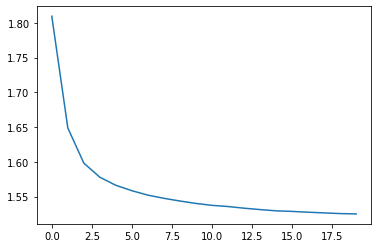

In [ ]:
#Построение графиков
plt.plot(test_loss_history)

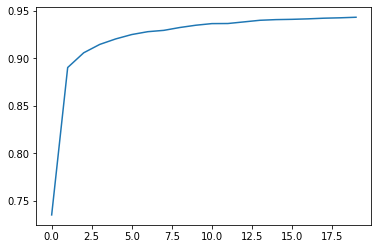

In [ ]:
plt.plot(test_accuracy_history)

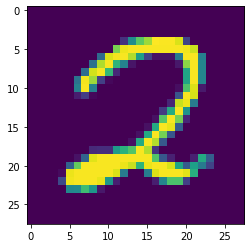

------------------
Прогноз модели: 2 
------------------



In [ ]:
X_to_predict = X_test[35]
###########
predicted_number = mnist_net.forward(X_to_predict).unsqueeze(0).cuda().detach().cpu().clone().numpy()
plt.imshow(X_to_predict.cpu().reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)

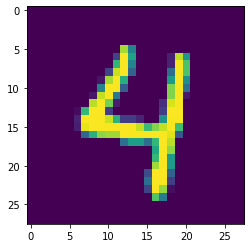

------------------
Прогноз модели: 4 
------------------



In [ ]:
X_to_predict = X_test[27]
###########
predicted_number = mnist_net.forward(X_to_predict).unsqueeze(0).cuda().detach().cpu().clone().numpy()
plt.imshow(X_to_predict.cpu().reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)

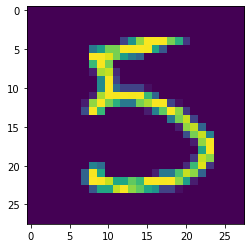

------------------
Прогноз модели: 5 
------------------



In [ ]:
X_to_predict = X_test[15]
###########
predicted_number = mnist_net.forward(X_to_predict).unsqueeze(0).cuda().detach().cpu().clone().numpy()
plt.imshow(X_to_predict.cpu().reshape(28,28))
plt.show()
print("------------------\nПрогноз модели: {} \n------------------\n".format(
    np.argmax(predicted_number)) 
)